In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 676, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 676 (delta 80), reused 0 (delta 0), pack-reused 570
Receiving objects: 100% (676/676), 13.51 MiB | 18.23 MiB/s, done.
Resolving deltas: 100% (420/420), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 19.3 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperparameters-tuning-better/best_params_ials_v2.json
/kaggle/input/hyperparameters-tuning-better/__results__.html
/kaggle/input/hyperparameters-tuning-better/better_tuning.db
/kaggle/input/hyperparameters-tuning-better/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning-better/__output__.json
/kaggle/input/hyperparameters-tuning-better/custom.css
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/rp3-tuning.ipynb
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning-better/Recsys_Challenge_2023/run_hyperparameter_search.py
/kaggle/input/hyperparameters-tuning-better/Re

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2162


In [8]:
config = {
    'tune_parameters_item_knn': False,
    'tune_parameters_user_knn': True,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/better_tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/better_tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


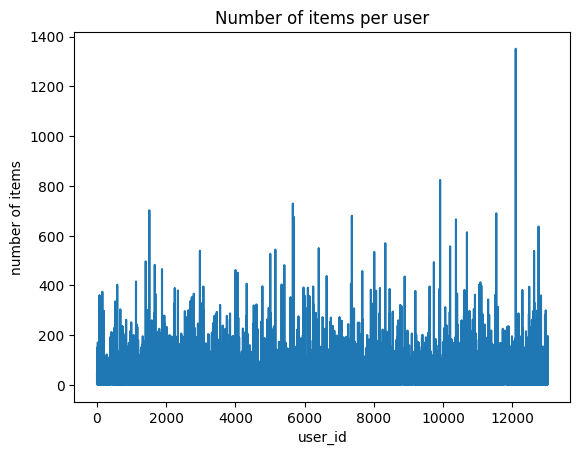

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

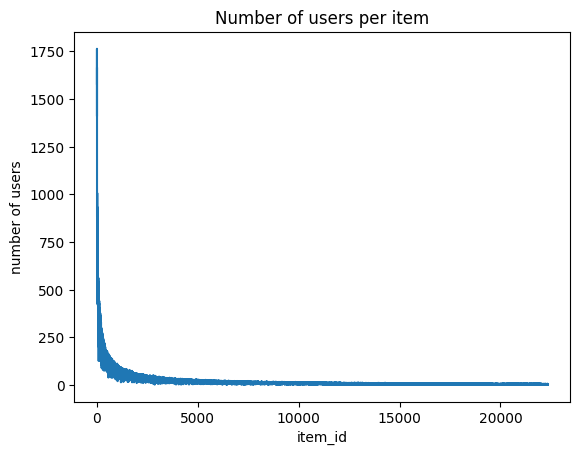

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

# Hyperparameters tuning

In [24]:
import sqlite3

def print_all_rows(table_name, database_path):
    connection = sqlite3.connect(database_path)
    cursor = connection.cursor()

    try:
        cursor.execute(f"SELECT * FROM {table_name};")
        rows = cursor.fetchall()

        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        cursor.close()
        connection.close()

print_all_rows('studies', config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_tuning_knn_item')
(2, 'hyperparameters_tuning_knn_user')
(3, 'hyperparameters_tuning_ials_no_cv')


## Item KNN Collaborative Filtering

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [25]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, params):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [26]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=50)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.9 µs


In [27]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [28]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [29]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [30]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [31]:
def evaluate_user_knn(URM_train, URM_valid, params):
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(**params)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']

def objective_user_knn(trial):
    params = {
        'topK': trial.suggest_int('topK', 10, 1000),
        'shrink': trial.suggest_int('shrink', 0, 500),
        'similarity': trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky", "euclidean"]),        
    }
    
    if params['similarity'] == "asymmetric":
        params["asymmetric_alpha"] = trial.suggest_float("asymmetric_alpha", 0, 2, log=False)
        params["normalize"] = True     

    elif params['similarity'] == "tversky":
        params["tversky_alpha"] = trial.suggest_float("tversky_alpha", 0, 2, log=False)
        params["tversky_beta"] = trial.suggest_float("tversky_beta", 0, 2, log=False)
        params["normalize"] = True 

    elif params['similarity'] == "euclidean":
        params["normalize_avg_row"] = trial.suggest_categorical("normalize_avg_row", [True, False])
        params["similarity_from_distance_mode"] = trial.suggest_categorical("similarity_from_distance_mode", ["lin", "log", "exp"])
        params["normalize"] = trial.suggest_categorical("normalize", [True, False])
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_user_knn, URM_train, URM_valid, params))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user_fixed',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=50)

[I 2023-11-25 17:53:16,005] A new study created in RDB with name: hyperparameters_tuning_knn_user_fixed


UserKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:01:35,009] Trial 0 finished with value: 0.009926910016854699 and parameters: {'topK': 703, 'shrink': 273, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'lin', 'normalize': True}. Best is trial 0 with value: 0.009926910016854699.


MAP is 0.013080361009043702
MAP is 0.012912901507118744
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11

[I 2023-11-25 18:04:18,410] Trial 1 finished with value: 0.012170648587929139 and parameters: {'topK': 124, 'shrink': 212, 'similarity': 'tversky', 'tversky_alpha': 0.03516473653311514, 'tversky_beta': 0.555340816727599}. Best is trial 1 with value: 0.012170648587929139.


UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1458 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:07:03,700] Trial 2 finished with value: 0.013877827349881527 and parameters: {'topK': 460, 'shrink': 209, 'similarity': 'tversky', 'tversky_alpha': 1.4548353837912515, 'tversky_beta': 1.4100863988477719}. Best is trial 2 with value: 0.013877827349881527.


UserKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:09:52,536] Trial 3 finished with value: 0.013214724897802756 and parameters: {'topK': 958, 'shrink': 329, 'similarity': 'tversky', 'tversky_alpha': 1.61595220862897, 'tversky_beta': 0.6189010482389137}. Best is trial 2 with value: 0.013877827349881527.


MAP is 0.017649941674419876
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1460 (11.2%) users with no interacti

[I 2023-11-25 18:12:41,866] Trial 4 finished with value: 0.013670359875911345 and parameters: {'topK': 665, 'shrink': 207, 'similarity': 'cosine'}. Best is trial 2 with value: 0.013877827349881527.


MAP is 0.018449554010394716
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-25 18:18:53,078] Trial 5 finished with value: 0.011847134189147557 and parameters: {'topK': 266, 'shrink': 372, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'exp', 'normalize': True}. Best is trial 2 with value: 0.013877827349881527.


UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1417 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:21:34,197] Trial 6 finished with value: 0.01365232053629877 and parameters: {'topK': 239, 'shrink': 191, 'similarity': 'tanimoto'}. Best is trial 2 with value: 0.013877827349881527.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:29:09,175] Trial 7 finished with value: 0.0012748958604047868 and parameters: {'topK': 710, 'shrink': 474, 'similarity': 'euclidean', 'normalize_avg_row': False, 'similarity_from_distance_mode': 'lin', 'normalize': False}. Best is trial 2 with value: 0.013877827349881527.


MAP is 0.0018217293242407651
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1413 (10.8%) users with no interact

[I 2023-11-25 18:31:52,669] Trial 8 finished with value: 0.013668120745260642 and parameters: {'topK': 440, 'shrink': 494, 'similarity': 'dice'}. Best is trial 2 with value: 0.013877827349881527.


UserKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:34:41,990] Trial 9 finished with value: 0.013354334773445675 and parameters: {'topK': 979, 'shrink': 0, 'similarity': 'tanimoto'}. Best is trial 2 with value: 0.013877827349881527.


MAP is 0.017483357946055152
MAP is 0.017329557490255772
MAP is 0.017646535079823902
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
UserKNNCFRecomm

[I 2023-11-25 18:37:25,861] Trial 10 finished with value: 0.012136951554870878 and parameters: {'topK': 482, 'shrink': 81, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.8297975731056502}. Best is trial 2 with value: 0.013877827349881527.


MAP is 0.016824798375031168
UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1437 (11.0%) users with no interacti

[I 2023-11-25 18:40:12,449] Trial 11 finished with value: 0.013662368844416406 and parameters: {'topK': 636, 'shrink': 141, 'similarity': 'cosine'}. Best is trial 2 with value: 0.013877827349881527.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:42:56,883] Trial 12 finished with value: 0.013744265686011803 and parameters: {'topK': 563, 'shrink': 100, 'similarity': 'jaccard'}. Best is trial 2 with value: 0.013877827349881527.


MAP is 0.01841617267665766
MAP is 0.01835678491199483
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1454 (11.2

[I 2023-11-25 18:45:42,975] Trial 13 finished with value: 0.01394952516963155 and parameters: {'topK': 367, 'shrink': 92, 'similarity': 'jaccard'}. Best is trial 13 with value: 0.01394952516963155.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1399 (10.7%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:48:30,908] Trial 14 finished with value: 0.01424744748997126 and parameters: {'topK': 360, 'shrink': 0, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1370 (10.5%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 18:51:17,811] Trial 15 finished with value: 0.014202796515751685 and parameters: {'topK': 268, 'shrink': 3, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.019291251795710087
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interacti

[I 2023-11-25 18:53:58,026] Trial 16 finished with value: 0.011469318803900074 and parameters: {'topK': 53, 'shrink': 4, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.017207223507700486
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interacti

[I 2023-11-25 18:56:38,281] Trial 17 finished with value: 0.014083016680221563 and parameters: {'topK': 271, 'shrink': 54, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.018896221770159264
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1444 (11.1%) users with no interacti

[I 2023-11-25 18:59:21,090] Trial 18 finished with value: 0.01327962279844031 and parameters: {'topK': 168, 'shrink': 143, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:02:07,418] Trial 19 finished with value: 0.01421133730237939 and parameters: {'topK': 356, 'shrink': 37, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1470 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:04:52,878] Trial 20 finished with value: 0.014131282159500744 and parameters: {'topK': 388, 'shrink': 44, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.018760232769308653
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1461 (11.2%) users with no interacti

[I 2023-11-25 19:07:33,964] Trial 21 finished with value: 0.014169245676113686 and parameters: {'topK': 330, 'shrink': 35, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
UserKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1422 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:10:13,120] Trial 22 finished with value: 0.013136966593703985 and parameters: {'topK': 164, 'shrink': 144, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:12:56,906] Trial 23 finished with value: 0.013348375694884215 and parameters: {'topK': 575, 'shrink': 0, 'similarity': 'asymmetric', 'asymmetric_alpha': 0.048963132383244456}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.017474436517646293
MAP is 0.018206328149949578
UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1409 (10

[I 2023-11-25 19:15:38,347] Trial 24 finished with value: 0.011009871723713045 and parameters: {'topK': 45, 'shrink': 61, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.01665317486746048
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactio

[I 2023-11-25 19:18:22,389] Trial 25 finished with value: 0.013997558906201652 and parameters: {'topK': 333, 'shrink': 108, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:21:07,448] Trial 26 finished with value: 0.01354875926311581 and parameters: {'topK': 796, 'shrink': 36, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.017765312771121495
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1436 (11.0%) users with no interacti

[I 2023-11-25 19:23:48,621] Trial 27 finished with value: 0.013443501516407674 and parameters: {'topK': 232, 'shrink': 274, 'similarity': 'jaccard'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:26:30,545] Trial 28 finished with value: 0.011906853255723446 and parameters: {'topK': 410, 'shrink': 130, 'similarity': 'asymmetric', 'asymmetric_alpha': 1.9346052003534224}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:29:10,922] Trial 29 finished with value: 0.013675168111112353 and parameters: {'topK': 311, 'shrink': 407, 'similarity': 'tanimoto'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.01820575070409446
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactio

[I 2023-11-25 19:31:59,778] Trial 30 finished with value: 0.01366906113885193 and parameters: {'topK': 583, 'shrink': 263, 'similarity': 'cosine'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.01841480970188062
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1379 (10.6%) users with no interactio

[I 2023-11-25 19:34:39,655] Trial 31 finished with value: 0.014206845953370666 and parameters: {'topK': 329, 'shrink': 29, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.019135021041302165
MAP is 0.01915983809170679
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1469 (11.

[I 2023-11-25 19:37:19,259] Trial 32 finished with value: 0.014001959238185832 and parameters: {'topK': 195, 'shrink': 23, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.019313373950202002
UserKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1440 (11.1%) users with no interacti

[I 2023-11-25 19:39:56,610] Trial 33 finished with value: 0.013277890343387277 and parameters: {'topK': 127, 'shrink': 67, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1434 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:42:42,011] Trial 34 finished with value: 0.014206405754340633 and parameters: {'topK': 514, 'shrink': 26, 'similarity': 'tversky', 'tversky_alpha': 0.6736531022225781, 'tversky_beta': 1.7851703759693671}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.018887868681751623
UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1456 (11.2%) users with no interacti

[I 2023-11-25 19:45:30,297] Trial 35 finished with value: 0.013895566211682059 and parameters: {'topK': 501, 'shrink': 171, 'similarity': 'tversky', 'tversky_alpha': 0.6553856176443075, 'tversky_beta': 1.8070078691553462}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 1475 (11.3%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:48:15,598] Trial 36 finished with value: 0.01413282597958428 and parameters: {'topK': 436, 'shrink': 63, 'similarity': 'tversky', 'tversky_alpha': 0.910958528755295, 'tversky_beta': 1.9845622902555153}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 19:51:01,640] Trial 37 finished with value: 0.013938554624665552 and parameters: {'topK': 522, 'shrink': 115, 'similarity': 'tversky', 'tversky_alpha': 1.9229359596799682, 'tversky_beta': 1.1915199616751164}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.018341447109643527
UserKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1425 (10.9%) users with no interacti

[I 2023-11-25 19:57:08,421] Trial 38 finished with value: 0.0011666943583167355 and parameters: {'topK': 373, 'shrink': 27, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'log', 'normalize': False}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.0017827467907907263
UserKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1443 (11.1%) users with no interact

[I 2023-11-25 19:59:55,635] Trial 39 finished with value: 0.013526978085798674 and parameters: {'topK': 687, 'shrink': 296, 'similarity': 'tversky', 'tversky_alpha': 0.4707585265372056, 'tversky_beta': 1.5493484463669012}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.017818863568780378
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1456 (11.2%) users with no interacti

[I 2023-11-25 20:02:42,038] Trial 40 finished with value: 0.013449481163424315 and parameters: {'topK': 750, 'shrink': 181, 'similarity': 'dice'}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 20:05:28,317] Trial 41 finished with value: 0.01358108567540422 and parameters: {'topK': 289, 'shrink': 19, 'similarity': 'tversky', 'tversky_alpha': 1.182599751687345, 'tversky_beta': 0.005835282117417906}. Best is trial 14 with value: 0.01424744748997126.


UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1461 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 20:10:43,669] Trial 42 finished with value: 0.0010786318903288133 and parameters: {'topK': 222, 'shrink': 81, 'similarity': 'euclidean', 'normalize_avg_row': True, 'similarity_from_distance_mode': 'log', 'normalize': False}. Best is trial 14 with value: 0.01424744748997126.


MAP is 0.0013651754529795175
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
UserKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1429 (11.0%) users with no interact

[I 2023-11-25 20:13:26,243] Trial 43 finished with value: 0.014248222966684704 and parameters: {'topK': 351, 'shrink': 17, 'similarity': 'dice'}. Best is trial 43 with value: 0.014248222966684704.


UserKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
UserKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 20:16:07,692] Trial 44 finished with value: 0.014042809449369984 and parameters: {'topK': 447, 'shrink': 47, 'similarity': 'dice'}. Best is trial 43 with value: 0.014248222966684704.


UserKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1430 (11.0%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 20:18:47,872] Trial 45 finished with value: 0.013652145936671764 and parameters: {'topK': 350, 'shrink': 227, 'similarity': 'dice'}. Best is trial 43 with value: 0.014248222966684704.


MAP is 0.01850081440673191
MAP is 0.01860940954920065
UserKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
UserKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
UserKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1421 (10.9

[I 2023-11-25 20:21:28,513] Trial 46 finished with value: 0.013931697230525317 and parameters: {'topK': 402, 'shrink': 86, 'similarity': 'dice'}. Best is trial 43 with value: 0.014248222966684704.


MAP is 0.019216358978422183
UserKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
UserKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
UserKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
UserKNNCFRecommender: URM Detected 1471 (11.3%) users with no interacti

[I 2023-11-25 20:24:12,561] Trial 47 finished with value: 0.013952953115636699 and parameters: {'topK': 529, 'shrink': 24, 'similarity': 'tanimoto'}. Best is trial 43 with value: 0.014248222966684704.


UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1421 (10.9%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 20:26:58,303] Trial 48 finished with value: 0.01395107992534834 and parameters: {'topK': 466, 'shrink': 63, 'similarity': 'cosine'}. Best is trial 43 with value: 0.014248222966684704.


UserKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
UserKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
UserKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
UserKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
UserKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
UserKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
UserKNNCFRecommender: U

[I 2023-11-25 20:29:39,079] Trial 49 finished with value: 0.013647289829777236 and parameters: {'topK': 625, 'shrink': 376, 'similarity': 'dice'}. Best is trial 43 with value: 0.014248222966684704.


CPU times: user 3h 18min 56s, sys: 55min 46s, total: 4h 14min 42s
Wall time: 2h 36min 23s


In [33]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning-better/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

# Alternating Least Squares

In [37]:
def objective_ials(trial):
    params = {
        'reg': trial.suggest_float('reg', 1e-7, 10, log=True),
        'alpha': trial.suggest_float('alpha', 0.01, 10),
        'num_factors': trial.suggest_int('num_factors', 5, 300),
        'confidence_scaling': trial.suggest_categorical('confidence_scaling', ['linear', 'log'])
    }
    
    if params['confidence_scaling'] == 'log':
        params['epsilon'] = trial.suggest_float('epsilon', 0.1, 10, log=True)
        
    evaluator_validation = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    early_stopping_params = {
        'epochs_min': 1,
        'stop_on_validation': True,
        'validation_every_n': 1,
        'validation_metric': 'MAP',
        'lower_validations_allowed': 15,
        'evaluator_object': evaluator_validation
    }

    recommender = IALSRecommender(URM_train)
    recommender.fit(**params, **early_stopping_params)
    
    epochs = recommender.get_early_stopping_final_epochs_dict()["epochs"]
    trial.set_user_attr("epochs", epochs) 

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

In [38]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials_no_cv',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=5)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.78 µs


In [39]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials_v2.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials_v2.json', 
            'tuning_results/best_params_ials_v2.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials_v2.json', 
        '/kaggle/working/best_params_ials_v2.json'
    )

In [43]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/better_tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [44]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [45]:
# user_ids_test.info()

In [46]:
# user_ids_test.head(5)

In [47]:
# user_ids_test['user_id'].unique()

In [48]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [49]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)